<img src="header.png" align="left"/>

# Exercise Import of excel data and timeseries prediction (10 points)

The goal of this example is to show the work with time series from Excel files and to develop a prediction model for time series. The data set describes the development of passenger numbers of an airline in the distant past. However, the data is typical for data as found in SME's (e.g. sales figures). 


The code for this example was adapted from [1]. Further information is available here [2]. 

- [1] [https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- [2] [https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa](https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa)


Citation dataset:
```
Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.
```


# Import of modules

In [1]:
import os
import openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (16,9)

In [2]:
#
# handle error messages
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

In [3]:
#
# Für GPU Support
#
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2.3.1


# Constants

In [4]:
excelData = 'data/airline_passengers.xlsx'

# Read the data from Excel file

In [5]:
data = pd.ExcelFile(excelData)
print(data.sheet_names)

['Tabellenblatt1']


In [6]:
#
# read one table
#
df = data.parse('Tabellenblatt1')
df.info
df.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,Month,Passengers
3,NaN,1949-01-01 00:00:00,112
4,NaN,1949-02-01 00:00:00,118
5,NaN,1949-03-01 00:00:00,132
6,NaN,1949-04-01 00:00:00,129
7,NaN,1949-05-01 00:00:00,121
8,NaN,1949-06-01 00:00:00,135
9,NaN,1949-07-01 00:00:00,148


In [7]:
df.tail()

,Unnamed: 0,Unnamed: 1,Unnamed: 2
142,NaN,1960-08-01 00:00:00,606
143,NaN,1960-09-01 00:00:00,508
144,NaN,1960-10-01 00:00:00,461
145,NaN,1960-11-01 00:00:00,390
146,NaN,1960-12-01 00:00:00,432


# Cut out data from pandas dataframes

Tutorial: [https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/](https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)

<img src="info.png" align="left"/> 

In [8]:
#
# cut out data
#
# Task: cut out the data from the dataframe using the iloc function described above to have 
# only relevant data left (timestamp and passenger number, no NaNs) (2 points)
#

# Exclute first n rows [n:]
# Select last n columns [:, -n:]
df_cut = df.iloc[3:, -2:]

# Check for any NaN / null in dataframe
df_cut.isnull().values.any()

False

In [9]:
df_cut.head()

,Unnamed: 1,Unnamed: 2
3,1949-01-01 00:00:00,112
4,1949-02-01 00:00:00,118
5,1949-03-01 00:00:00,132
6,1949-04-01 00:00:00,129
7,1949-05-01 00:00:00,121


In [10]:
# rename columns to fixed names
df_cut.columns = ['month','passengers']

In [11]:
df_cut.head()

,month,passengers
3,1949-01-01 00:00:00,112
4,1949-02-01 00:00:00,118
5,1949-03-01 00:00:00,132
6,1949-04-01 00:00:00,129
7,1949-05-01 00:00:00,121


Text(0, 0.5, 'time')

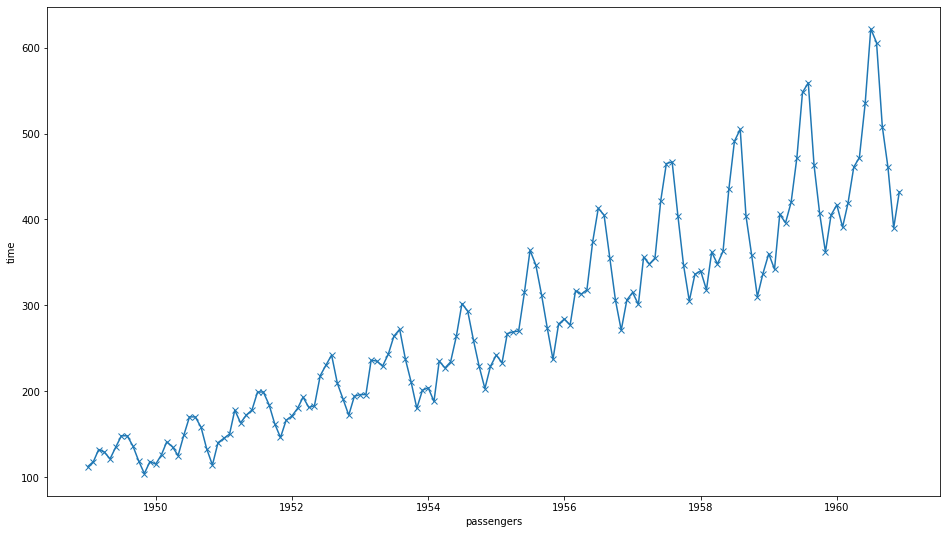

In [12]:
#
# plot number of passangers
#
# Task: plot the passenger data from the pandas dataframe (1 point)
#


# Let's firstly take a look at how the passenger count increases over time
# We are lucky to already eveything sorted per month

plt.plot(df_cut['month'], df_cut['passengers'], marker='x')
plt.xlabel('passengers')
plt.ylabel('time')

# Description: the plot below shows that the number of passengers is steadily increasing
# every year. We can also see that the variance increases exponentially.

In [13]:
# Let's say we now want to take a look at the average (mean) of passengers per year

# Firstly we need to get the all distinct years within the dataframe
def years_in_frame():
    return df_cut['month'].map(lambda t: t.date().year)

years_in_frame()

3      1949
4      1949
5      1949
6      1949
7      1949
       ... 
142    1960
143    1960
144    1960
145    1960
146    1960
Name: month, Length: 144, dtype: int64

In [14]:
# now we can easily get all values per year, like so
years = years_in_frame().unique()
df_cut.loc[years_in_frame() == years[0]]

,month,passengers
3,1949-01-01 00:00:00,112
4,1949-02-01 00:00:00,118
5,1949-03-01 00:00:00,132
6,1949-04-01 00:00:00,129
7,1949-05-01 00:00:00,121
8,1949-06-01 00:00:00,135
9,1949-07-01 00:00:00,148
10,1949-08-01 00:00:00,148
11,1949-09-01 00:00:00,136
12,1949-10-01 00:00:00,119


In [15]:
# Lets now iterate over the years and calculat the mean
mean_values = [np.mean(df_cut.loc[years_in_frame() == years[k], ['passengers']].to_numpy()) for k in range(years.shape[-1])]
mean_values

[126.66666666666667,
 139.66666666666666,
 170.16666666666666,
 197.0,
 225.0,
 238.91666666666666,
 284.0,
 328.25,
 368.4166666666667,
 381.0,
 428.3333333333333,
 476.1666666666667]

Text(0, 0.5, 'average passengers')

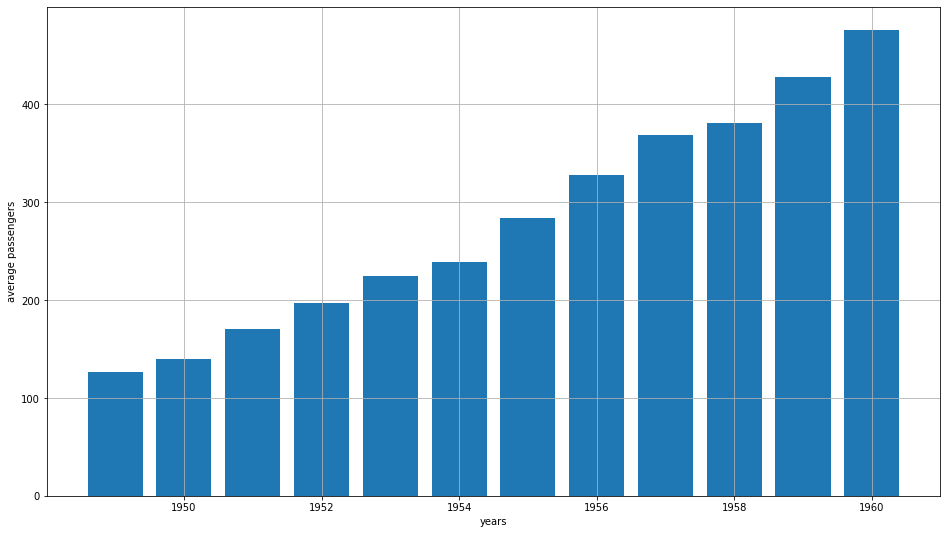

In [16]:
# Finally we can plot the resulst
plt.bar(years, mean_values)
plt.grid()
plt.xlabel('years')
plt.ylabel('average passengers')

# Conventional methods

There are many older methods to work with time series:

- https://machinelearningmastery.com/time-series-trends-in-python/
- https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa


The main purpose of these methods is the calculation and use of parameters such as **trend** and **seasonality**. We hope that our models can handle them without us having to explicitly deal with them.

<img src="info.png" align="left"/> 

In [17]:
#
# prepare data
#
x_data = df_cut['passengers'].values
x_data = x_data.astype('float32')
x_data = np.reshape(x_data,(-1,1)) # makes each item an array -> [[], [], [], ...]
print(x_data)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]


In [18]:
#
# Normalize the dataset
#
# Task: create a minmax scaler from sklearn to scale the data between 0 and 1 and store the trained scaler in
# a python variable called scaler (2 points)
#

# Ref: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
scaler = MinMaxScaler()
scaler.fit(x_data)

MinMaxScaler()

In [19]:
print(scaler.data_max_)

[622.]


In [20]:
#
# actually scale the data
#
x_data = scaler.transform(x_data)
print(x_data)

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123553]
 [0.04247104]
 [0.07142857]
 [0.05984557]
 [0.04054055]
 [0.08687258]
 [0.12741312]
 [0.12741312]
 [0.10424709]
 [0.05598456]
 [0.01930502]
 [0.06949806]
 [0.07915059]
 [0.08880308]
 [0.14285713]
 [0.11389962]
 [0.13127413]
 [0.14285713]
 [0.18339768]
 [0.18339768]
 [0.15444016]
 [0.11196911]
 [0.08108109]
 [0.1196911 ]
 [0.12934363]
 [0.14671814]
 [0.17181468]
 [0.14864865]
 [0.15250966]
 [0.22007722]
 [0.24324325]
 [0.26640925]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374519]
 [0.17760617]
 [0.17760617]
 [0.25482625]
 [0.25289574]
 [0.24131274]
 [0.26833975]
 [0.3088803 ]
 [0.32432434]
 [0.25675675]
 [0.20656371]
 [0.14671814]
 [0.18725869]
 [0.19305018]
 [0.16216215]
 [0.25289574]
 [0.23745173]
 [0.25096524]
 [0.3088803 ]
 [0.38223937]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.1911197 ]
 [0.24

In [21]:
#
# split into train and test sets with 80% training data
#
train_size = int(len(x_data) * 0.80)
test_size = len(x_data) - train_size
train, test = x_data[0:train_size,:], x_data[train_size:len(x_data),:]
print(len(train), len(test))

115 29


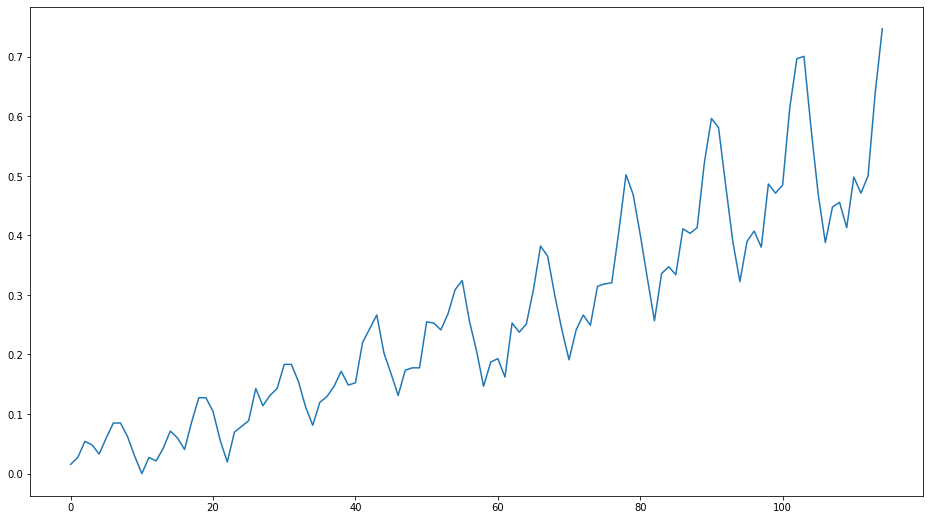

In [22]:
#
# plot scaled training data for check
#
plt.plot(train)

# Create a training data set with sliding windows

Sliding windows are created from a time series by dragging a window over the entire time series and copying the data in the window. More details here [https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe](https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe).

<img src="info.png" align="left"/> 

In [23]:
#
# create sliding windows with one label (y)
#
# Task: add comments for the details of this function (1 point)
#


def createSlidingWindowsWithLabel(dataset, look_back=1):
    # create two empty arrays
    dataX, dataY = [], []
    
    # iterate over window size
    for i in range(len(dataset)-look_back-1):
        # all items from current count until window size
        a = dataset[ i:(i+look_back), 0]
        # add above to return variable
        dataX.append(a)
        # all items starting from window size
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [26]:
#
# apply sliding window function with window size (window_length)
#
window_length = 1
trainX, trainY = createSlidingWindowsWithLabel(train, window_length)
testX, testY = createSlidingWindowsWithLabel(test, window_length)

In [27]:
# 
# reshape input to be [samples, time steps, features]
#
trainX = np.reshape(trainX, (trainX.shape[0], window_length, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], window_length, testX.shape[1]))

# Create an LSTM model

In [28]:
# some hyperparameters
epochs = 100
batch_size = 4

In [29]:
#
# create and fit the LSTM network
#
def createLSTMModel():
    model = Sequential()
    model.add(LSTM(6, input_shape=(1, window_length)))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [31]:
lstm_model = createLSTMModel()

In [32]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = lstm_model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(testX, testY), shuffle=False)

Epoch 1/100
29/29 [==============================] - 0s 9ms/step - loss: 0.0740 - val_loss: 0.3420
Epoch 2/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0517 - val_loss: 0.2785
Epoch 3/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.2295
Epoch 4/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1917
Epoch 5/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0242 - val_loss: 0.1630
Epoch 6/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0215 - val_loss: 0.1417
Epoch 7/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0201 - val_loss: 0.1260
Epoch 8/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0194 - val_loss: 0.1144
Epoch 9/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0189 - val_loss: 0.1057
Epoch 10/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0185 - val_loss: 0.0989
Epoch 11/

29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 84/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 85/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 86/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 87/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 88/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 89/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 90/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 91/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 92/100
29/29 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 93/100


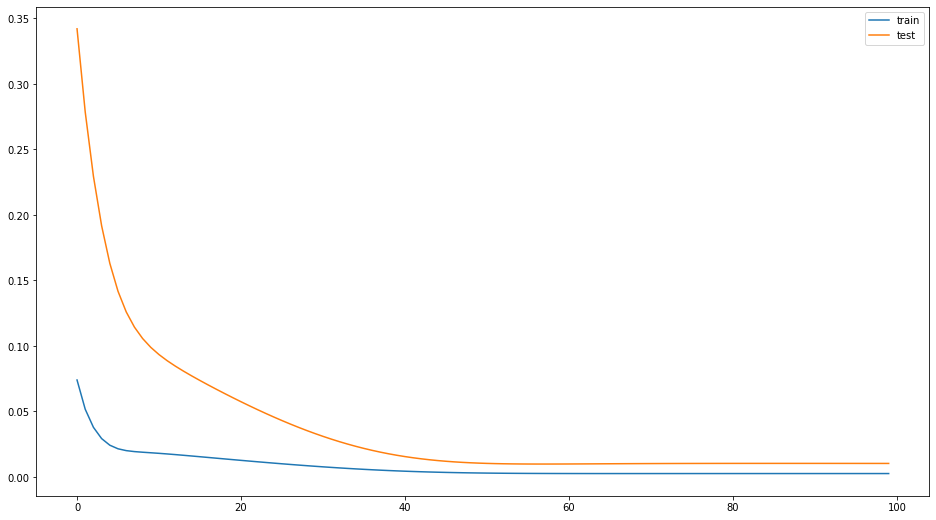

In [34]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [35]:
#
# Estimate values for train and test data
#
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

In [36]:
#
# Inverse transformation of estimations (scaler)
#
trainPredicti = scaler.inverse_transform(trainPredict)
testPredicti = scaler.inverse_transform(testPredict)

trainYi = scaler.inverse_transform([trainY])
testYi = scaler.inverse_transform([testY])

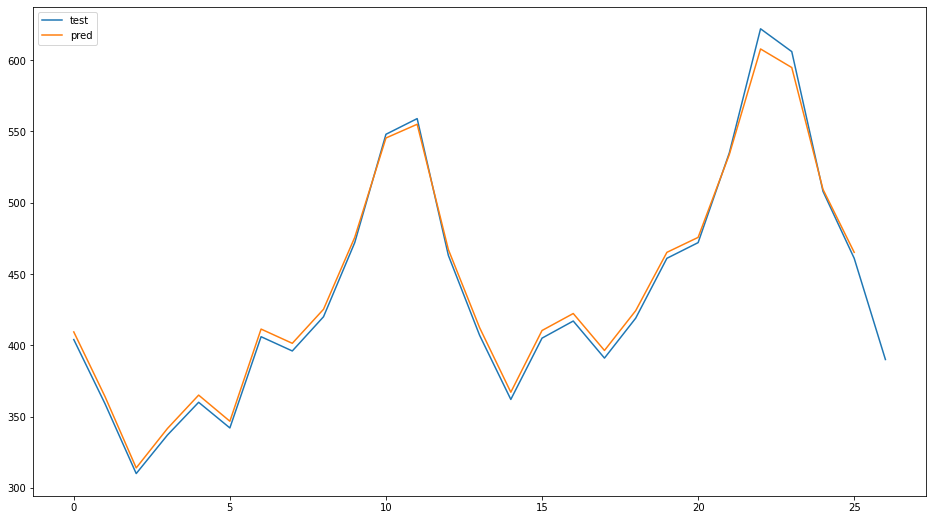

In [37]:
#
# Plot estimations
#
plt.plot(testYi[0,0:], label='test')
plt.plot(testPredicti[1:,0], label='pred')
plt.legend(loc='upper left')
plt.show()

In [38]:
testYi[0,0:-1]

array([403.99999397, 359.00001333, 310.00001073, 337.00000838,
       359.99999952, 342.00000109, 406.0000281 , 395.99998094,
       420.00002002, 471.99998119, 548.00004318, 559.00001477,
       462.99998197, 407.00001429, 362.00000277, 404.99998016,
       416.9999997 , 390.99998824, 418.99997208, 461.00000959,
       471.99998119, 535.00003745, 622.00000929, 606.00004499,
       507.99997805, 461.00000959])

In [39]:
#
# calculate root mean squared error
#
# Task: calculate the root mean squared error between the test labels and the prediction (1 point)
# Hint: labels are in testYi[0,0:-1]
#       predictions are in testPredicti[1:,0]

trainScore = mean_squared_error(trainYi[0,0:-1], trainPredicti[1:,0])
print('train loss: %.3f RMSE' % (trainScore))
testScore = mean_squared_error(testYi[0,0:-1], testPredicti[1:,0])
print('test loss: %.3f RMSE' % (testScore))

train loss: 17.804 RMSE
test loss: 31.538 RMSE


# Plot complete timeline

In [40]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(x_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[:len(trainPredicti)+0, :] = trainPredicti

# shift test predictions for plotting
testPredictPlot = np.empty_like(x_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredicti)+(window_length*2):len(x_data)-2, :] = testPredicti

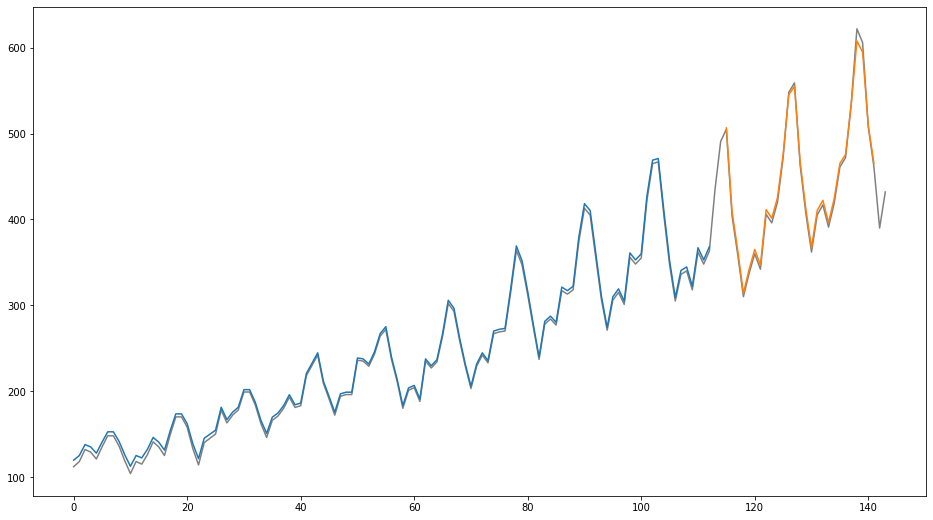

In [41]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(x_data), color='grey')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Experiment with different window and model sizes (3 points)

**change request**: The customer wants a better prediction quality. Conduct an experiment with a different window_length. Another option is to increase the capacity of the model. Compare the resulting RMSE values. 
Hopefully, this increases the quality of the prediction.

In [52]:
#
# apply sliding window function with window size (window_length)
#
window_length = 5
trainX, trainY = createSlidingWindowsWithLabel(train, window_length)
testX, testY = createSlidingWindowsWithLabel(test, window_length)

# reshape
trainX = np.reshape(trainX, (trainX.shape[0], window_length, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], window_length, testX.shape[1]))

ValueError: cannot reshape array of size 545 into shape (109,5,5)

In [43]:
history = lstm_model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(testX, testY), shuffle=False)

Epoch 1/100


ValueError: in user code:

    /home/daniel/.local/share/virtualenvs/mlexercises-E8JZtc1P/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/daniel/.local/share/virtualenvs/mlexercises-E8JZtc1P/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/daniel/.local/share/virtualenvs/mlexercises-E8JZtc1P/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/daniel/.local/share/virtualenvs/mlexercises-E8JZtc1P/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/daniel/.local/share/virtualenvs/mlexercises-E8JZtc1P/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/daniel/.local/share/virtualenvs/mlexercises-E8JZtc1P/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/daniel/.local/share/virtualenvs/mlexercises-E8JZtc1P/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/daniel/.local/share/virtualenvs/mlexercises-E8JZtc1P/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/daniel/.local/share/virtualenvs/mlexercises-E8JZtc1P/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 5]
